In [2]:
import matplotlib
import pylab as plt
import astropy
import astropy.units as u
from astropy.io import fits
from astropy import constants as const
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter
# NOTE, you need the in-development version of speclite (check out from https://github.com/desihub/speclite) to get the
# new LSST filters (the notebook will fail otherwise).
#import speclite.filters
import sys
import os

In [3]:
# Alternatives study for the imaging required for Spec-S5.

In [4]:
# eg if you have a git checkout of speclite in the current directory, you'll want
sys.path.insert(0, './speclite')
import speclite.filters
print(speclite.filters.__file__)
# Check that it's a new version that knows about the new version of the LSST filter curves
speclite.filters.load_filters('lsst2023-u', 'lsst2023-g')

/Users/dstn/cfht-etc/speclite/speclite/filters.py


In [5]:
# This is just a copy of the Astrometry.net astrometry/util/fits.py file - yet another FITS table wrapper
from an_fits import fits_table

In [52]:
# Assumed survey area in sq deg
#survey_area = 11000
# DESI-2
survey_area = 5000

In [108]:
# Medium-band filters -- we're going to assume constant-throughput, top-hat filters.
# This is the constant throughput
mb_eff = 0.95
# These are the edges of the filters -- so MB0 is 3750-4006 A, MB1 is 4006-4265, etc.
mb_limits = [3750, 4006, 4265, 4519, 4779, 5036, 5297, 5507]

In [65]:
# These are the line fluxes we assume for MB0-6, in units of 1e-16 erg/s/cm^2.
#mb_line_fluxes = [1.30, 1.17, 1.03, 0.90, 0.77, 0.64, 0.50]
# Arjun's Variable Luminosity Function version
#mb_line_fluxes = [0.7, 0.7, 0.6, 0.6, 0.5, 0.5, 0.5]
# Arjun's Constant Luminosity Function version
#mb_line_fluxes = [1.5, 1.2, 1.0, 0.8, 0.7, 0.6, 0.5]

# Interpolating in Arjun's Variable Luminosity Function matrix
#mb_line_fluxes = [0.58, 0.75, 0.69, 0.65, 0.58, 0.56, 0.5]

# Anand -- 4000/sq deg
#mb_line_fluxes = [1.01, 0.86, 0.73, 0.64, 0.55, 0.47, 0.36]

# Anand -- 3000/sq deg
#mb_line_fluxes = [1.17, 1.01, 0.86, 0.76, 0.65, 0.56, 0.43]

# Anand -- DESI-2 1000/sq deg
mb_line_fluxes = [1.92, 1.66, 1.43, 1.28, 1.12, 0.96, 0.77]

'''
# FILT ZMIN ZMAX FLIM NLAE_PER_MPC3 NLAE_PER_DEG2
MB0    2.08    2.30    1.17e-16    3.7e-03    430
MB1    2.30    2.51    1.01e-16    3.7e-03    431
MB2    2.51    2.72    8.60e-17    3.7e-03    439
MB3    2.72    2.93    7.60e-17    3.7e-03    430
MB4    2.93    3.14    6.50e-17    3.7e-03    426
MB5    3.14    3.36    5.60e-17    3.7e-03    418
N540    3.36    3.53    4.30e-17    3.7e-03    410
''';

In [66]:
# Hours per night assumed in the final reporting
hrs_per_night = 10.

In [67]:
# Seeing and effective telescope diameters

seeings = {
    'CFHT': 0.8,
    'HSC': 0.8,
    'Rubin': 1.0,
    'DECam': 1.2,
    'Spec-S5': 1.2,
}

tel_diams = {
    'CFHT': 3.196 * u.m, # CFHT web page: effective area after obstructions = 80,216 cm^2 - https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/specsinformation.html
    'HSC': 8.2 * u.m, ## ????? effective area must be smaller
    'Rubin': 6.423 * u.m, # https://smtn-002.lsst.io/
    'DECam': 3.51 * u.m, # DECam ETC spreadsheet, v7: 9.70 sq m, https://noirlab.edu/science/programs/ctio/instruments/Dark-Energy-Camera/User-Guide/Exposure-Time-Calculator-ETC-0
    'Spec-S5': 4.913 * u.m, ## Effective area 18.96 sq m from 6mOpticsFeasibility-v2.pdf
}

In [68]:
pixscales = {
    'CFHT'   : 0.185,
    'HSC'    : 0.168,
    'Rubin'  : 0.2,
    'DECam'  : 0.262,
    'Spec-S5': 0.16,
}

# Number of pixels in the camera
cam_pix = {
    'CFHT':    40 * 2048 * 4612,
    'DECam':   60 * 2048 * 4096,
    'HSC':    104 * 2048 * 4096,  # effective number of chips given vignetting etc?
    'Rubin':  189 * 4096 * 4096,
    'Spec-S5': 64 * 6144 * 6160, # Teledyne/e2v CCD231-C6
}

# Effective area per exposure, in square degrees
cam_sqdeg = {}
for k,v in cam_pix.items():
    cam_sqdeg[k] = v * (pixscales[k]/3600.)**2
cam_sqdeg

{'CFHT': 0.9977407209876543,
 'DECam': 2.6658685534814817,
 'HSC': 1.899926505244445,
 'Rubin': 9.786709333333334,
 'Spec-S5': 4.784613451851853}

In [137]:
# Assumed galaxy size (Gaussian sigma), in arcsec
gal_size = 0.15 # arcsec

# Target S/N of source detection
snr = 5.

In [138]:
# Another "magic number" is the correction we apply to the LSST model sky spectrum.
# Search for "sky_scale" below.

In [139]:
# Now define a few functions for reading data files...

In [140]:
def read_lsst_throughput(fn, basedir='lsst-throughputs-1.9', wave_factor = 10.,
                        assert_2_words=True):
    fullfn = os.path.join(basedir, fn)
    vals = []
    for line in open(fullfn).readlines():
        line = line.strip()
        if line.startswith('#'):
            continue
        words = line.split()
        if len(words) == 0:
            continue
        if assert_2_words:
            assert(len(words) == 2)
        vals.append((float(words[0]), float(words[1])))
    vals = np.array(vals)
    # Bizarro subaru m1 file is not sorted!!
    I = np.argsort(vals[:,0])
    vals = vals[I,:]
    # Wavelength (nm->A), throughput
    return vals[:,0] * wave_factor, vals[:,1]

In [141]:
def read_uves_spectrum(fn):
    hdu = fits.open(fn)[0]
    hdr = hdu.header
    sky_flux = hdu.data
    crpix, crval, cdelt = hdr['CRPIX1'], hdr['CRVAL1'], hdr['CDELT1']
    sky_pix = (1 + np.arange(len(sky_flux)))
    sky_wave = crval + (sky_pix - crpix) * cdelt
    return sky_wave, sky_flux

In [142]:
# Read CFHT data tables...
def read_table(fn, wavelengths, sep=None, wave_scale=10., trans_scale=0.01):
    f = open(fn)
    qe = []
    for line in f.readlines():
        words = line.strip().split(sep=sep)
        #if len(words) != 2:
        #    continue
        try:
            f1,f2 = float(words[0]), float(words[1])
        except:
            continue
        qe.append([wave_scale * f1, trans_scale * f2])
    qe = np.array(qe)
    if wavelengths is None:
        return qe
    qe_wave = qe[:,0] * u.Angstrom
    qe_frac = qe[:,1]
    qe = np.interp(wavelengths, qe_wave, qe_frac)
    return qe

In [143]:
# First up, read the dark sky model.  We have three available:
# - UVES - from https://www.eso.org/observing/dfo/quality/UVES/pipeline/sky_spectrum.html
#               https://ui.adsabs.harvard.edu/abs/2003A%26A...407.1157H/abstract
# - DESI - used for DESI sims
#          https://desi.lbl.gov/trac/browser/code/desimodel/trunk/data/spectra/spec-sky.dat
# - LSST - estimated for predictions; version 1.9 of
#          https://github.com/lsst/throughputs/blob/1.9/baseline/darksky.dat

In [144]:
# the UVES spectra are split into pieces... join them together
wave1,flux1 = read_uves_spectrum('fluxed_sky_346.fits')
wave2,flux2 = read_uves_spectrum('fluxed_sky_437.fits')
wave3,flux3 = read_uves_spectrum('fluxed_sky_580L.fits')
split12 = 3760.
split23 = 4850.
I1 = (wave1 < split12)
I2 = (wave2 >= split12) * (wave2 < split23)
I3 = (wave3 >= split23)
sky_wave = np.hstack((wave1[I1], wave2[I2], wave3[I3]))
sky_flux = np.hstack((flux1[I1], flux2[I2], flux3[I3]))
# The UVES sky fluxes are in 1e-16 erg/(s A cm^2 arcsec^2)
uves_sky_wave = sky_wave * u.Angstrom
# per arcsec^2
uves_sky_flux = sky_flux * 1e-16 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [145]:
# Next, a spectrum used for DESI sims.
#desi_sky = read_table('spec-sky.dat', sky_wave_u, wave_scale=1., trans_scale=1.)
desi_sky = read_table('spec-sky-cut.dat', None, wave_scale=1., trans_scale=1.)
desi_sky_wave = desi_sky[:,0] * u.Angstrom
desi_sky_flux = desi_sky[:,1] * 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom)

In [146]:
# Finally, the dark sky model from the LSST throughputs repo
w,f = read_lsst_throughput('darksky.dat')
# is in "Flambda(ergs/cm^s/s/nm)"
f *= 0.1 # -> to ergs/cm^2/s/A
lsst_sky_wave = w * u.Angstrom
lsst_sky_flux = f * u.erg / (u.cm**2 * u.s * u.Angstrom)
#lsst_sky = interp1d(w,f)
#lsst_sky = interp1d(wavegrid, lsst_sky, bounds_error=False, fill_value=0.)
#lsst_sky_u = lsst_sky(sky_wave_u) * sky_flux_u.unit

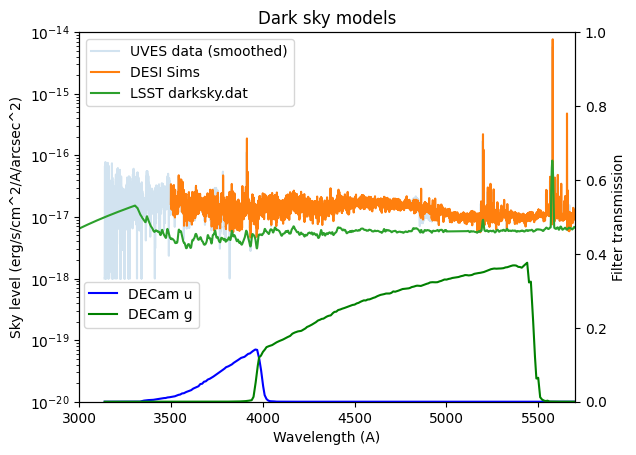

In [147]:
decam_filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g')

uves2 = gaussian_filter(uves_sky_flux, 5.)
plt.semilogy(uves_sky_wave, np.maximum(1e-18, uves2),  label='UVES data (smoothed)', alpha=0.2);
#plt.semilogy(uves_sky_wave, np.maximum(1e-18, uves_sky_flux.value),  label='UVES data', alpha=0.2);
plt.semilogy(desi_sky_wave, desi_sky_flux, label='DESI Sims');
plt.semilogy(lsst_sky_wave, lsst_sky_flux, label='LSST darksky.dat');
plt.legend()
plt.ylim(1e-20, 1e-14);
plt.xlabel('Wavelength (A)')
plt.ylabel('Sky level (erg/s/cm^2/A/arcsec^2)')
plt.xlim(3000, 5700)

# Also plot the DECam u,g filters
plt.twinx()
plt.plot(uves_sky_wave, decam_filters[0].interpolator(uves_sky_wave), 'b', label='DECam u')
plt.plot(uves_sky_wave, decam_filters[1].interpolator(uves_sky_wave), 'g', label='DECam g')
plt.ylim(0,1)
plt.ylabel('Filter transmission')
plt.legend(loc=(0.01, 0.2))#'lower left')

plt.title('Dark sky models')
plt.savefig('sky.png')

In [148]:
# ... from which we can see that the LSST model is considerably more optimistic...

In [149]:
filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g', 'bessell-U', 'bessell-B', 'cfht_megacam-u', 'cfht_megacam-g')

print('UVES sky model:')
for f in filters:
    sky_flux,sky_wave = f.pad_spectrum(uves_sky_flux, uves_sky_wave, method='zero')
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(sky_flux, sky_wave))

print()
print('DESI sky model:  --  NOTE that the cfht-u and bessell-U are wrong because the spectrum is truncated')
for f in filters:
    sky_flux,sky_wave = f.pad_spectrum(desi_sky_flux, desi_sky_wave, method='zero')
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(sky_flux, sky_wave))

print()
print('LSST sky model:')
for f in filters:
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(lsst_sky_flux, lsst_sky_wave))    

UVES sky model:
Filter     decam2014-u : sky is 21.82 mag / arcsec^2
Filter     decam2014-g : sky is 21.40 mag / arcsec^2
Filter       bessell-U : sky is 21.79 mag / arcsec^2
Filter       bessell-B : sky is 21.46 mag / arcsec^2
Filter  cfht_megacam-u : sky is 21.78 mag / arcsec^2
Filter  cfht_megacam-g : sky is 21.40 mag / arcsec^2

DESI sky model:  --  NOTE that the cfht-u and bessell-U are wrong because the spectrum is truncated
Filter     decam2014-u : sky is 21.85 mag / arcsec^2
Filter     decam2014-g : sky is 21.39 mag / arcsec^2
Filter       bessell-U : sky is 22.21 mag / arcsec^2
Filter       bessell-B : sky is 21.46 mag / arcsec^2
Filter  cfht_megacam-u : sky is 22.08 mag / arcsec^2
Filter  cfht_megacam-g : sky is 21.40 mag / arcsec^2

LSST sky model:
Filter     decam2014-u : sky is 22.85 mag / arcsec^2
Filter     decam2014-g : sky is 22.23 mag / arcsec^2
Filter       bessell-U : sky is 22.90 mag / arcsec^2
Filter       bessell-B : sky is 22.49 mag / arcsec^2
Filter  cfht_megac

In [150]:
# Which one should we use?
# This paper
#   https://ui.adsabs.harvard.edu/abs/2007PASP..119..687K/abstract
# gives CTIO average measurements of U ~ 22.12 and B ~ 22.82 (Table 6)

# The Dark Energy Survey DR1
#   https://ui.adsabs.harvard.edu/abs/2018ApJS..239...18A/abstract
# reports a median g ~ 22.01

# This web page
#   https://www.cfht.hawaii.edu/Instruments/Imaging/Megacam/quickinformation.html
# reports CFHT Megacam u ~ 22.70, g ~ 22.00 at zenith, 0% moon

In [151]:
# I am therefore going to take the LSST sky model but scale it to be 0.26 mag brighter!
sky_scaling = 10.**((-0.26) / -2.5)
sky_scaling

I = np.flatnonzero(lsst_sky_wave.value < 6000)
sky_wave = lsst_sky_wave[I]
sky_flux = lsst_sky_flux[I] * sky_scaling
print('Brightened LSST sky model:')
for f in filters:
    if 'bessell' in f.name:
        continue
    pf,pw = f.pad_spectrum(sky_flux, sky_wave, method='zero')   
    print('Filter %15s' % f.name, ': sky is %.2f mag / arcsec^2' % f.get_ab_magnitude(pf, pw))

Brightened LSST sky model:
Filter     decam2014-u : sky is 22.79 mag / arcsec^2
Filter     decam2014-g : sky is 22.00 mag / arcsec^2
Filter  cfht_megacam-u : sky is 22.71 mag / arcsec^2
Filter  cfht_megacam-g : sky is 22.02 mag / arcsec^2


In [152]:
# Next up, we try to figure out transmission curves for each telescope under consideration.
# In general, we're doing this by referring to information produced by each observatory.
# For comparison, we have 'speclite' filter curves for some combinations.

In [153]:
wavegrid = sky_wave

In [154]:
# LSST: from the "throughputs" repository.
pieces = ['detector', 'lens1', 'lens2', 'lens3', 'm1', 'm2', 'm3']
thru = np.ones(len(wavegrid))
thru_pieces = {}
for p in pieces:
    pf = interp1d(*read_lsst_throughput(p+'.dat'))
    thru_pieces[p] = pf
    pf = pf(wavegrid)
    thru *= pf
lsst_thru = interp1d(wavegrid, thru)

lsst_filt_u = interp1d(*read_lsst_throughput('filter_u.dat'))
lsst_filt_g = interp1d(*read_lsst_throughput('filter_g.dat'))

In [155]:
# HSC:
#  https://www.naoj.org/Observing/Instruments/HSC/txt/qe_ccd_HSC.txt
#  https://www.naoj.org/Observing/Instruments/HSC/txt/throughput_popt2.txt
#  https://www.naoj.org/Observing/Instruments/HSC/txt/throughput_win.txt
#  https://www.naoj.org/Observing/Telescope/Parameters/Reflectivity/subaru_m1_r_20221013.txt
# Mirror is reported in %, not throughput.
pieces = [('qe_ccd_HSC.txt', 1., 1.),
          ('subaru_m1_r_20221013.txt', 10., 0.01),
          #('subaru_m1_r_20180129.txt', 10., 0.01),
          ('throughput_popt2.txt', 1., 1.),
          ('throughput_win.txt', 1., 1.),
         ]
hsc_thru = np.ones(len(wavegrid))
for p,wf,tf in pieces:
    w,t = read_lsst_throughput(p, basedir='hsc', wave_factor=1, assert_2_words=False)
    pf = interp1d(w*wf, t*tf, bounds_error=False, fill_value=0.)
    hsc_thru *= pf(wavegrid)
hsc_thru = interp1d(wavegrid, hsc_thru)

In [156]:
# CFHT:
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/QE_camera.dat
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/Optics_TR.dat
# https://www.cfht.hawaii.edu/Science/CFHTLS-OLD/MSWG/Al_coating.dat
# https://www.cfht.hawaii.edu/Instruments/Filters/curves/cfh9302.dat
# from https://www.cfht.hawaii.edu/Instruments/Filters/megaprime.html

# CCD QE
qe = read_table('cfht/QE_camera.dat', sky_wave)
# Optics_TR.dat
optics = read_table('cfht/Optics_TR.dat', sky_wave)
# Mirror - Al_coating.dat
mirror = read_table('cfht/Al_coating.dat', sky_wave)

cfht_thru = interp1d(sky_wave, qe * optics * mirror)

# Filters - 
cfht_u_filt    = interp1d(sky_wave, read_table('cfht/cfh9302.dat', sky_wave, sep=','))
cfht_g_filt    = interp1d(sky_wave, read_table('cfht/cfh9402.dat', sky_wave, sep=','))
cfht_cahk_filt = interp1d(sky_wave, read_table('cfht/cfh9303.dat', sky_wave, sep=','))

In [157]:
# For DECam, we did not try to find the individual transmission curves, and will instead scale the 'speclite'
# filter curves, below.

In [158]:
# Spec-S5 -- could use the LSST CCD QE curve, which is in-line with the datasheet "typical QE" curve for the
# deep-depletion silicon, astro broadband, for Teledyne/e2v CCD231-C6...
# ... or just be optimistic and assume it is as good as CFHT!
specs5_thru = cfht_thru

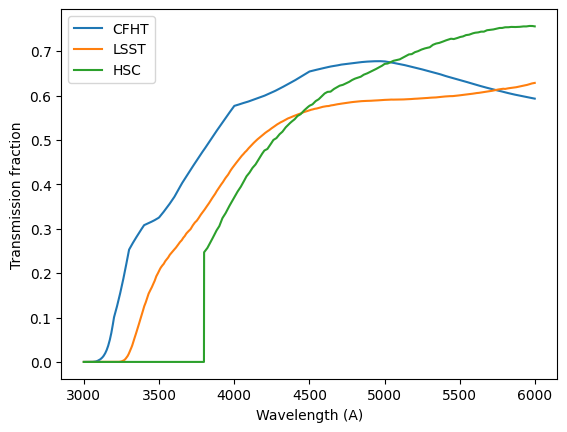

In [159]:
plt.plot(wavegrid, cfht_thru(wavegrid), label='CFHT')
plt.plot(wavegrid, lsst_thru(wavegrid), label='LSST')
plt.plot(wavegrid, hsc_thru(wavegrid),  label='HSC');
plt.legend()
plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission fraction');

In [160]:
# Define Medium-band filters
MB = []
for lo,hi in zip(mb_limits, mb_limits[1:]):
    f = interp1d(wavegrid, mb_eff * (wavegrid.value >= lo) * (wavegrid.value < hi), bounds_error=False, fill_value=0.)
    MB.append(f)

In [161]:
# Names for MB filters
mbnames = {}
for i in range(7):
    mbnames[i] = ' MB%i' % i
mbnames[7] = '   u'
mbnames[8] = 'CaHK'

# Set line fluxes of 1e-16 for u, CaHK.
#mb_line_fluxes.extend([1.0, 1.0])
mb_line_fluxes.extend([2.0, 1.0])


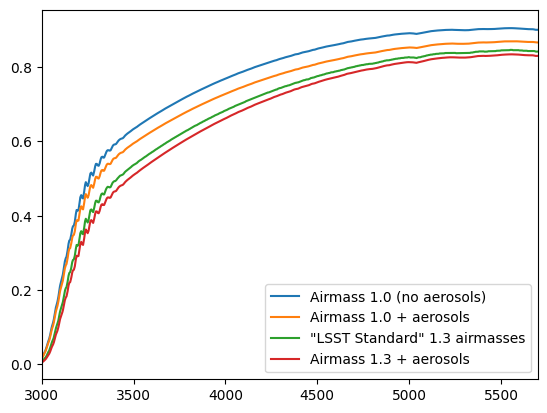

In [162]:
# Another big choice we have is the atmosphere model.  The LSST sims have a variety of models,
# at different airmasses, and with/without aerosols.  These make quite a big difference!
atm = interp1d(*read_lsst_throughput('atmos_std.dat'))
atm10 = interp1d(*read_lsst_throughput('atmos_10.dat'))
atm10_noaero = interp1d(*read_lsst_throughput('atmos_10.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_hi = interp1d(*read_lsst_throughput('atmos_12_hiwater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_lo = interp1d(*read_lsst_throughput('atmos_12_lowater.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
# Water doesn't make a difference for us in the blue -- but aerosols do!
#atm12_hi_a = interp1d(*read_lsst_throughput('atmos_12_hiwater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
#atm12_lo_a = interp1d(*read_lsst_throughput('atmos_12_lowater_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
atm13_a = interp1d(*read_lsst_throughput('atmos_13_aerosol.dat', basedir='/Users/dstn/lsst-throughputs/atmos'))
wave = sky_wave
plt.plot(wave, atm10_noaero(wave), label='Airmass 1.0 (no aerosols)')
plt.plot(wave, atm10(wave), label='Airmass 1.0 + aerosols')
plt.plot(wave, atm(wave), label='"LSST Standard" 1.3 airmasses')
plt.plot(wave, atm13_a(wave), label='Airmass 1.3 + aerosols')
plt.xlim(3000, 5700)
plt.legend();

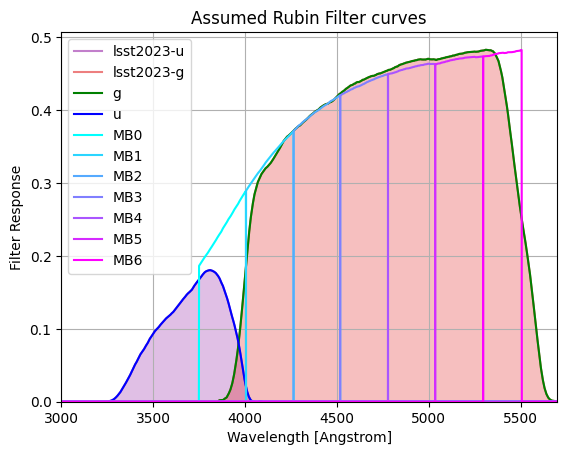

In [163]:
lsst_atm = atm

lsst_filters = speclite.filters.load_filters('lsst2023-u', 'lsst2023-g')
speclite.filters.plot_filters(lsst_filters)

plt.plot(wavegrid, lsst_thru(wavegrid) * lsst_atm(wavegrid) * lsst_filt_g(wavegrid), color='g', label='g')
plt.plot(wavegrid, lsst_thru(wavegrid) * lsst_atm(wavegrid) * lsst_filt_u(wavegrid), color='b', label='u')

cm = matplotlib.cm.cool
for i,mb in enumerate(MB):
    plt.plot(wavegrid, lsst_thru(wavegrid) * lsst_atm(wavegrid) * mb(wavegrid),
             color=cm(i/6), label='MB%i'%i)
plt.legend();
plt.xlim(3000, 5700);
plt.title('Assumed Rubin Filter curves');

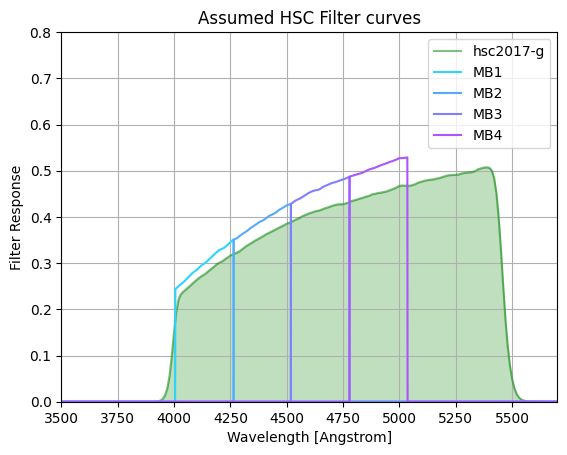

In [164]:
# Use "standard" model for HSC
hsc_atm = atm

# Show HSC filters
speclite.filters.plot_filters(speclite.filters.load_filters('hsc2017-g'))
cm = matplotlib.cm.cool
for i,mb in enumerate(MB):
    if i < 1 or i > 4:
        continue
    plt.plot(wavegrid, hsc_thru(wavegrid) * hsc_atm(wavegrid) * mb(wavegrid),
             color=cm(i/6), label='MB%i'%i)
plt.legend();
plt.ylim(0,0.8);
plt.xlim(3500, 5700);
plt.title('Assumed HSC Filter curves');

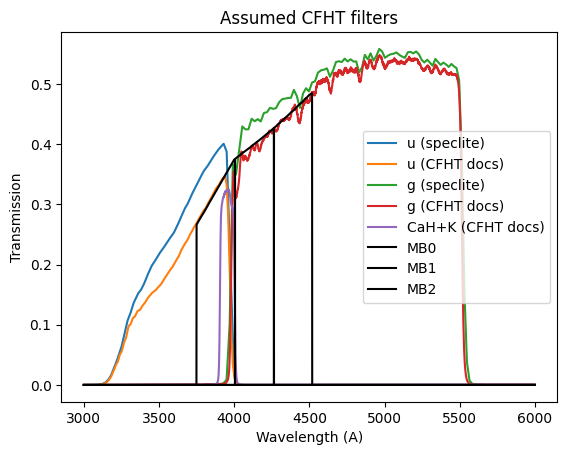

In [165]:
cfht_filters = speclite.filters.load_filters('cfht_megacam-u', 'cfht_megacam-g')

cfht_atm = atm

atmo = cfht_atm(sky_wave)
thru = cfht_thru(sky_wave)
#speclite.filters.plot_filters(cfht_filters)
plt.plot(sky_wave, cfht_filters[0].interpolator(sky_wave), label='u (speclite)');
plt.plot(sky_wave, thru * cfht_u_filt(sky_wave) * atmo, label='u (CFHT docs)');
plt.plot(sky_wave, cfht_filters[1].interpolator(sky_wave), label='g (speclite)');
plt.plot(sky_wave, thru * cfht_g_filt(sky_wave) * atmo, label='g (CFHT docs)');
plt.plot(sky_wave, thru * cfht_cahk_filt(sky_wave) * atmo, label='CaH+K (CFHT docs)');

plt.plot(sky_wave, thru * MB[0](sky_wave) * atmo, color='k', label='MB0');
plt.plot(sky_wave, thru * MB[1](sky_wave) * atmo, color='k', label='MB1');
plt.plot(sky_wave, thru * MB[2](sky_wave) * atmo, color='k', label='MB2');

plt.xlabel('Wavelength (A)')
plt.ylabel('Transmission')
plt.title('Assumed CFHT filters')
plt.legend();

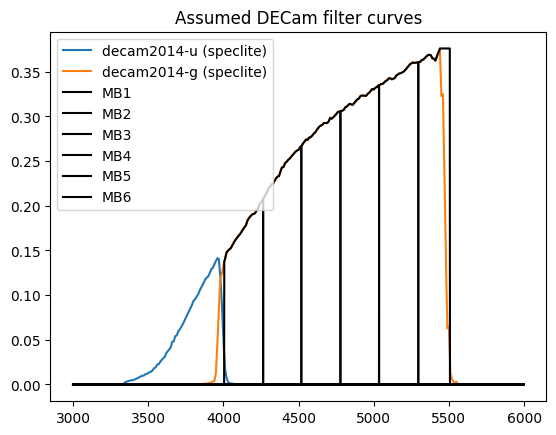

In [166]:
decam_filters = speclite.filters.load_filters('decam2014-u', 'decam2014-g')
for f in decam_filters:
    plt.plot(sky_wave, f.interpolator(sky_wave), label=f.name + ' (speclite)')

decam_g = decam_filters[1].interpolator
decam_thru = decam_g(sky_wave)
# The g-band transmission drops off before the r-band picks up -- assume the throughput would actually
# be flat at the max g value.  This avoids suppressing the red end of MB6.
i = np.argmax(decam_thru)
decam_thru[i:] = decam_thru[i]
# Correct for the assumed 95% MB throughput
decam_thru /= mb_eff
decam_thru = interp1d(sky_wave.value, decam_thru)

# This decam_thru already has atmospheric extinction, so set to 1.0
decam_atm = lambda x: np.ones(len(x))

for i,mb in enumerate(MB):
    if i < 1:
        continue
    plt.plot(wavegrid, decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid),
             color='k', label='MB%i'%i)
plt.title('Assumed DECam filter curves')
plt.legend(loc='upper left');

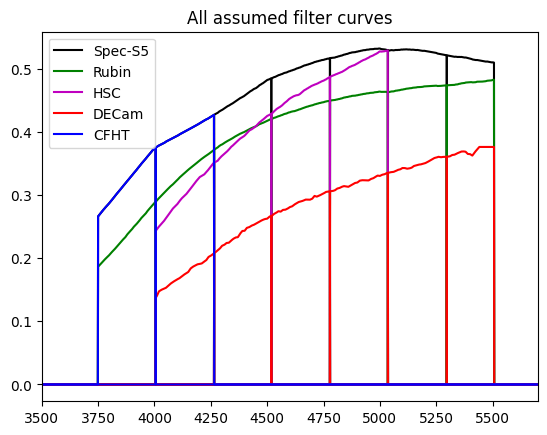

In [167]:
combos = []

def thrufunc(w,tel,atm,mb):
    f = interp1d(wavegrid, tel(wavegrid)*atm(wavegrid)*mb(wavegrid), bounds_error=False, fill_value=0.)
    return f

for i,mb in enumerate(MB):
    kwa = {}
    if i == 0:
        kwa.update(label='Spec-S5')
    plt.plot(wavegrid, cfht_thru(wavegrid) * cfht_atm(wavegrid) * mb(wavegrid),
             color='k', **kwa)
    combos.append(('Spec-S5', i, thrufunc(wavegrid, cfht_thru, cfht_atm, mb)))#lambda x: cfht_thru(x) * cfht_atm(x) * mb(x)))

for i,mb in enumerate(MB):
    kwa = {}
    if i == 0:
        kwa.update(label='Rubin')
    plt.plot(wavegrid, lsst_thru(wavegrid) * lsst_atm(wavegrid) * mb(wavegrid),
             color='g', **kwa)
    combos.append(('Rubin', i, thrufunc(wavegrid, lsst_thru, lsst_atm, mb)))##lambda x: lsst_thru(x) * lsst_atm(x) * mb(x)))

for i,mb in enumerate(MB):
    if i < 1 or i > 4:
        continue
    kwa = {}
    if i == 1:
        kwa.update(label='HSC')
    plt.plot(wavegrid, hsc_thru(wavegrid) * hsc_atm(wavegrid) * mb(wavegrid),
             color='m', **kwa)
    combos.append(('HSC', i, thrufunc(wavegrid, hsc_thru, hsc_atm, mb)))#lambda x: hsc_thru(x) * hsc_atm(x) * mb(x)))

for i,mb in enumerate(MB):
    if i < 1:
        continue
    kwa = {}
    if i == 1:
        kwa.update(label='DECam')
    plt.plot(wavegrid, decam_thru(wavegrid) * decam_atm(wavegrid) * mb(wavegrid),
             color='r', **kwa)
    combos.append(('DECam', i, thrufunc(wavegrid, decam_thru, decam_atm, mb)))

plt.plot(wavegrid, cfht_thru(wavegrid) * MB[0](wavegrid) * cfht_atm(wavegrid), color='b', label='CFHT');
plt.plot(wavegrid, cfht_thru(wavegrid) * MB[1](wavegrid) * cfht_atm(wavegrid), color='b');
combos.append(('CFHT', 0, thrufunc(wavegrid, cfht_thru, cfht_atm, MB[0])))
combos.append(('CFHT', 1, thrufunc(wavegrid, cfht_thru, cfht_atm, MB[1])))
combos.append(('CFHT', 2, thrufunc(wavegrid, cfht_thru, cfht_atm, MB[2])))
combos.append(('CFHT', 7, thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_u_filt)))
combos.append(('CFHT', 8, thrufunc(wavegrid, cfht_thru, cfht_atm, cfht_cahk_filt)))

plt.legend();
plt.xlim(3500, 5700);
plt.title('All assumed filter curves')
plt.savefig('thru.png')

In [168]:
# Define AB reference source flux
ref_mag = 20.
ref = speclite.filters.ab_reference_flux(sky_wave, magnitude=ref_mag)

In [169]:
# Energy of a photon of wavelength sky_wave_u
wave_ergs = (const.h.cgs * const.c.cgs / sky_wave).to('erg')
dwave = np.diff(sky_wave)
dwave = np.append(dwave, [dwave[-1]])

tel_area = 1. * u.m**2
ref_photon_rate = ref * dwave * tel_area / wave_ergs
sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs

sky_mags = {}

for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave))
    sky_photons = np.sum(sky_photon_rate * thru(sky_wave))
    sky_mag = ref_mag -2.5 * np.log10(sky_photons / ref_photons)
    sky_mags[(tel,mbi)] = sky_mag
    print('%10s %s: sky brightness is %.2f mag/arcsec^2' % (tel, mbnames[mbi], sky_mag))

   Spec-S5  MB0: sky brightness is 22.75 mag/arcsec^2
   Spec-S5  MB1: sky brightness is 22.36 mag/arcsec^2
   Spec-S5  MB2: sky brightness is 22.23 mag/arcsec^2
   Spec-S5  MB3: sky brightness is 22.06 mag/arcsec^2
   Spec-S5  MB4: sky brightness is 21.94 mag/arcsec^2
   Spec-S5  MB5: sky brightness is 21.83 mag/arcsec^2
   Spec-S5  MB6: sky brightness is 21.72 mag/arcsec^2
     Rubin  MB0: sky brightness is 22.75 mag/arcsec^2
     Rubin  MB1: sky brightness is 22.36 mag/arcsec^2
     Rubin  MB2: sky brightness is 22.23 mag/arcsec^2
     Rubin  MB3: sky brightness is 22.06 mag/arcsec^2
     Rubin  MB4: sky brightness is 21.94 mag/arcsec^2
     Rubin  MB5: sky brightness is 21.83 mag/arcsec^2
     Rubin  MB6: sky brightness is 21.72 mag/arcsec^2
       HSC  MB1: sky brightness is 22.36 mag/arcsec^2
       HSC  MB2: sky brightness is 22.23 mag/arcsec^2
       HSC  MB3: sky brightness is 22.06 mag/arcsec^2
       HSC  MB4: sky brightness is 21.94 mag/arcsec^2
     DECam  MB1: sky brightn

In [182]:
# Define line sources in the middle of each filter
srcs = []
limits = np.array(mb_limits)
# Wavelength of the line source...
# For CFHT u and CaH+K, 3950 Ang is pretty much the peak transmission
line_wave = np.append((limits[:-1] + limits[1:]) / 2., [3950.]*2)


In [193]:
#### HACK HACK HACK


mb_line_fluxes = mb_line_fluxes[:len(mbnames)]
mb_line_fluxes[7] = 5.
mb_line_fluxes

line_wave[7] = 3600.

In [194]:

for imb,mid in enumerate(line_wave):
    src = np.zeros(len(sky_wave))
    i = np.argmin(np.abs(sky_wave - mid*u.Angstrom))
    src[i] = (1e-16 / dwave[i].value)
    src = src * sky_flux.unit
    srcs.append(src)
    print('Filter %s:' % mbnames[imb], src[i]*dwave[i], 'at %.1f Ang' % mid)

Filter  MB0: 1e-16 erg / (s cm2) at 3878.0 Ang
Filter  MB1: 1e-16 erg / (s cm2) at 4135.5 Ang
Filter  MB2: 1e-16 erg / (s cm2) at 4392.0 Ang
Filter  MB3: 1e-16 erg / (s cm2) at 4649.0 Ang
Filter  MB4: 1e-16 erg / (s cm2) at 4907.5 Ang
Filter  MB5: 1e-16 erg / (s cm2) at 5166.5 Ang
Filter  MB6: 1e-16 erg / (s cm2) at 5402.0 Ang
Filter    u: 1e-16 erg / (s cm2) at 3600.0 Ang
Filter CaHK: 1e-16 erg / (s cm2) at 3950.0 Ang


In [195]:
ref_photon_rate = ref * dwave * tel_area / wave_ergs
print('For a line source of 1e-16 erg/sec/cm^2 centered in the filter...')
print()
src_mags = {}
for tel,mbi,thru in combos:
    ref_photons = np.sum(ref_photon_rate * thru(sky_wave))
    src_photon_rate = srcs[mbi] * dwave * tel_area / wave_ergs
    src_photons = np.sum(src_photon_rate * thru(sky_wave))
    src_mag = ref_mag -2.5 * np.log10(src_photons / ref_photons)

    src_photon_rate2 = srcs[mbi] * mb_line_fluxes[mbi] * dwave * tel_area / wave_ergs
    src_photons2 = np.sum(src_photon_rate2 * thru(sky_wave))
    src_mag2 = ref_mag -2.5 * np.log10(src_photons2 / ref_photons)
    
    src_mags[(tel,mbi)] = src_mag2

    print('%10s %s: source brightness is %.2f mag      (flux %6.2f:  mag %.2f)' % (tel, mbnames[mbi], src_mag,
                                                                                  mb_line_fluxes[mbi], src_mag2))

For a line source of 1e-16 erg/sec/cm^2 centered in the filter...

   Spec-S5  MB0: source brightness is 25.67 mag      (flux   1.92:  mag 24.96)
   Spec-S5  MB1: source brightness is 25.54 mag      (flux   1.66:  mag 24.99)
   Spec-S5  MB2: source brightness is 25.39 mag      (flux   1.43:  mag 25.00)
   Spec-S5  MB3: source brightness is 25.29 mag      (flux   1.28:  mag 25.02)
   Spec-S5  MB4: source brightness is 25.16 mag      (flux   1.12:  mag 25.04)
   Spec-S5  MB5: source brightness is 25.06 mag      (flux   0.96:  mag 25.11)
   Spec-S5  MB6: source brightness is 24.73 mag      (flux   0.77:  mag 25.02)
     Rubin  MB0: source brightness is 25.67 mag      (flux   1.92:  mag 24.96)
     Rubin  MB1: source brightness is 25.54 mag      (flux   1.66:  mag 24.99)
     Rubin  MB2: source brightness is 25.39 mag      (flux   1.43:  mag 25.00)
     Rubin  MB3: source brightness is 25.29 mag      (flux   1.28:  mag 25.02)
     Rubin  MB4: source brightness is 25.16 mag      (flux   1.1

In [196]:
print('For 1e-16 erg/sec/cm^2 line source...')
print()
psf_exp_times = []
gal_exp_times = []
for tel,mbi,thru in combos:
    pixel_size = pixscales[tel]
    tel_diam = tel_diams[tel]
    seeing = seeings[tel]
    # Source spectrum for this filter
    src = srcs[mbi]

    tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')
    #print('Telescope area for', tel, '=', tel_area)
    # from per-arcsec^2 to per-pixel
    sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * thru(sky_wave))
    # Total photon count
    src_photon_rate = src * dwave * tel_area / wave_ergs
    src_photon_rate = np.sum(src_photon_rate * thru(sky_wave))
    # Noise-equivalent area for the source
    sig = seeing / 2.35 # arcsec
    nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + gal_size**2) # in arcsec^2
    nea_psf = 4.*np.pi * sig**2 # arcsec^2
    nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
    nea_psf_pix = nea_psf / (pixel_size**2) # in pixels

    # Required exposure times
    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf    = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2
    gal_exp_times.append(t_galaxy)
    psf_exp_times.append(t_psf)

    print('%10s %s: Exp time for Galaxy: %7.1f sec, PSF: %7.1f sec' % (tel, mbnames[mbi], t_galaxy.value, t_psf.value))


For 1e-16 erg/sec/cm^2 line source...

   Spec-S5  MB0: Exp time for Galaxy:  1104.4 sec, PSF:  1009.0 sec
   Spec-S5  MB1: Exp time for Galaxy:  1065.8 sec, PSF:   973.8 sec
   Spec-S5  MB2: Exp time for Galaxy:   860.0 sec, PSF:   785.8 sec
   Spec-S5  MB3: Exp time for Galaxy:   786.1 sec, PSF:   718.3 sec
   Spec-S5  MB4: Exp time for Galaxy:   705.6 sec, PSF:   644.7 sec
   Spec-S5  MB5: Exp time for Galaxy:   675.9 sec, PSF:   617.5 sec
   Spec-S5  MB6: Exp time for Galaxy:   539.2 sec, PSF:   492.7 sec
     Rubin  MB0: Exp time for Galaxy:   637.5 sec, PSF:   557.9 sec
     Rubin  MB1: Exp time for Galaxy:   537.0 sec, PSF:   470.0 sec
     Rubin  MB2: Exp time for Galaxy:   415.3 sec, PSF:   363.4 sec
     Rubin  MB3: Exp time for Galaxy:   384.2 sec, PSF:   336.3 sec
     Rubin  MB4: Exp time for Galaxy:   344.9 sec, PSF:   301.9 sec
     Rubin  MB5: Exp time for Galaxy:   323.0 sec, PSF:   282.7 sec
     Rubin  MB6: Exp time for Galaxy:   246.4 sec, PSF:   215.7 sec
       HS

In [197]:
print('For varying line source strengths  (in units of 10^-16 erg/sec/cm^2)...')
print()
psf_exp_times_2 = []
gal_exp_times_2 = []

exp_time_map = {}

for tel,mbi,thru in combos:
    pixel_size = pixscales[tel]
    tel_diam = tel_diams[tel]
    seeing = seeings[tel]
    # Source spectrum for this filter ... will scale below
    src = srcs[mbi]
    line_flux = mb_line_fluxes[mbi]
    tel_area = (np.pi * (tel_diam / 2.)**2).to('cm^2')
    # from per-arcsec^2 to per-pixel
    sky_photon_rate = sky_flux * dwave * tel_area / wave_ergs * pixel_size**2
    sky_photon_rate = np.sum(sky_photon_rate * thru(sky_wave))
    # Total photon count
    src_photon_rate = src * line_flux * dwave * tel_area / wave_ergs
    src_photon_rate = np.sum(src_photon_rate * thru(sky_wave))
    # Noise-equivalent area for the source
    sig = seeing / 2.35 # arcsec
    nea_gal = 4.*np.pi * (sig**2 + (pixel_size**2/12.) + gal_size**2) # in arcsec^2
    nea_psf = 4.*np.pi * sig**2 # arcsec^2
    nea_gal_pix = nea_gal / (pixel_size**2) # in pixels
    nea_psf_pix = nea_psf / (pixel_size**2) # in pixels
    # Required exposure times
    t_galaxy = snr**2 * (sky_photon_rate * nea_gal_pix) / src_photon_rate**2
    t_psf    = snr**2 * (sky_photon_rate * nea_psf_pix) / src_photon_rate**2
    gal_exp_times_2.append(t_galaxy)
    psf_exp_times_2.append(t_psf)

    exp_time_map[tel, mbi] = t_galaxy
    print('%10s %s: Exp time for Galaxy with line flux %3.2f: %7.1f sec    (PSF: %7.1f sec)' %
          (tel, mbnames[mbi], line_flux, t_galaxy.value, t_psf.value))
          #, t_psf.value))
    #print('%10s %s: Exp time for Galaxy: %7.1f sec, PSF: %7.1f sec' % (tel, mbnames[mbi], t_galaxy.value, t_psf.value))


For varying line source strengths  (in units of 10^-16 erg/sec/cm^2)...

   Spec-S5  MB0: Exp time for Galaxy with line flux 1.92:   299.6 sec    (PSF:   273.7 sec)
   Spec-S5  MB1: Exp time for Galaxy with line flux 1.66:   386.8 sec    (PSF:   353.4 sec)
   Spec-S5  MB2: Exp time for Galaxy with line flux 1.43:   420.6 sec    (PSF:   384.3 sec)
   Spec-S5  MB3: Exp time for Galaxy with line flux 1.28:   479.8 sec    (PSF:   438.4 sec)
   Spec-S5  MB4: Exp time for Galaxy with line flux 1.12:   562.5 sec    (PSF:   513.9 sec)
   Spec-S5  MB5: Exp time for Galaxy with line flux 0.96:   733.4 sec    (PSF:   670.1 sec)
   Spec-S5  MB6: Exp time for Galaxy with line flux 0.77:   909.4 sec    (PSF:   830.9 sec)
     Rubin  MB0: Exp time for Galaxy with line flux 1.92:   172.9 sec    (PSF:   151.3 sec)
     Rubin  MB1: Exp time for Galaxy with line flux 1.66:   194.9 sec    (PSF:   170.6 sec)
     Rubin  MB2: Exp time for Galaxy with line flux 1.43:   203.1 sec    (PSF:   177.7 sec)
     Ru

In [106]:
print('For %g square degrees... (line fluxes in 10^-16 erg/sec/cm^2)' % survey_area)
print('Assuming %g-hour nights' % hrs_per_night)
print()
for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times_2):
    line_flux = mb_line_fluxes[mbi]
    fields = survey_area / cam_sqdeg[tel]
    f = fields / 3600. / hrs_per_night
    psf_nights = f * t_psf.value
    gal_nights = f * t_gal.value
#    print('%10s %s: PSF: %7.1f nights, Galaxy: %7.1f nights' % (tel, mbnames[mbi], psf_nights, gal_nights))
    print('%10s %s (line flux %3.2f): %7.1f nights' % (tel, mbnames[mbi], line_flux, gal_nights))


For 5000 square degrees... (line fluxes in 10^-16 erg/sec/cm^2)
Assuming 10-hour nights

   Spec-S5  MB0 (line flux 1.92):     7.7 nights
   Spec-S5  MB1 (line flux 1.66):    22.5 nights
   Spec-S5  MB2 (line flux 1.43):    17.6 nights
   Spec-S5  MB3 (line flux 1.28):    20.1 nights
   Spec-S5  MB4 (line flux 1.12):    23.5 nights
   Spec-S5  MB5 (line flux 0.96):    30.7 nights
   Spec-S5  MB6 (line flux 0.77):    38.0 nights
     Rubin  MB0 (line flux 1.92):     2.2 nights
     Rubin  MB1 (line flux 1.66):     5.8 nights
     Rubin  MB2 (line flux 1.43):     4.1 nights
     Rubin  MB3 (line flux 1.28):     4.8 nights
     Rubin  MB4 (line flux 1.12):     5.6 nights
     Rubin  MB5 (line flux 0.96):     7.2 nights
     Rubin  MB6 (line flux 0.77):     8.5 nights
       HSC  MB1 (line flux 1.66):    14.1 nights
       HSC  MB2 (line flux 1.43):     9.1 nights
       HSC  MB3 (line flux 1.28):     9.7 nights
       HSC  MB4 (line flux 1.12):    10.9 nights
     DECam  MB1 (line flux 1.

In [107]:
tele_order = ['CFHT', 'DECam', 'HSC', 'Rubin', 'Spec-S5']

print('Variable luminosity function,', survey_area, 'square deg, %i sigma' % snr)
print('Number of (%g-hour) nights for various telescopes' % hrs_per_night)
print()

print('       ', end='')
for t in tele_order:
    print('  & %8s' % t, end='')
print('  \\\\')

nights = {}
for ifilter in range(len(MB)):
    for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times_2):
        if mbi != ifilter:
            continue
        line_flux = mb_line_fluxes[mbi]
        fields = survey_area / cam_sqdeg[tel]
        f = fields / 3600. / hrs_per_night
        gal_nights = f * t_gal.value
        nights[(tel,mbi)] = gal_nights

    print(mbnames[ifilter], '  ', end='')
    for tel in tele_order:
        k = (tel,ifilter)
        if k in nights:
            print('  & %8.0f' % nights[k], end='')
        else:
            print('  &        -', end='')
    print('  \\\\')


Variable luminosity function, 5000 square deg, 6 sigma
Number of (10-hour) nights for various telescopes

         &     CFHT  &    DECam  &      HSC  &    Rubin  &  Spec-S5  \\
 MB0     &       43  &        -  &        -  &        2  &        8  \\
 MB1     &      126  &      172  &       14  &        6  &       22  \\
 MB2     &       99  &      116  &        9  &        4  &       18  \\
 MB3     &        -  &      123  &       10  &        5  &       20  \\
 MB4     &        -  &      137  &       11  &        6  &       24  \\
 MB5     &        -  &      167  &        -  &        7  &       31  \\
 MB6     &        -  &      195  &        -  &        8  &       38  \\


In [63]:
tele_order = ['CFHT', 'DECam']#, 'HSC', 'Rubin']

print('Variable luminosity function,', survey_area, 'square deg, %i sigma' % snr)
print('Number of (%g-hour) nights for various telescopes' % hrs_per_night)
print()

print('<table>')
print('<tr>')
print('<th></th>')
for t in tele_order:
    print('  <th>%8s</th>' % t, end='')
print('</tr>')


nights = {}
for ifilter in range(1, 6):
    print('<tr>')
    for (tel,mbi,thru),t_psf,t_gal in zip(combos, psf_exp_times, gal_exp_times_2):
        if mbi != ifilter:
            continue
        line_flux = mb_line_fluxes[mbi]
        fields = survey_area / cam_sqdeg[tel]
        f = fields / 3600. / hrs_per_night
        gal_nights = f * t_gal.value
        nights[(tel,mbi)] = gal_nights
    print('<th>%s</th>' % mbnames[ifilter])
    for tel in tele_order:
        k = (tel,ifilter)
        if k in nights:
            print('<td>%8.0f</td>' % nights[k], end='')
        else:
            print('<td></td>', end='')
    print('</tr>')
print('</table>')

Variable luminosity function, 5000 square deg, 6 sigma
Number of (10-hour) nights for various telescopes

<table>
<tr>
<th></th>
  <th>    CFHT</th>  <th>   DECam</th></tr>
<tr>
<th> MB1</th>
<td>      91</td><td>     132</td></tr>
<tr>
<th> MB2</th>
<td>      99</td><td>     116</td></tr>
<tr>
<th> MB3</th>
<td></td><td>     123</td></tr>
<tr>
<th> MB4</th>
<td></td><td>     137</td></tr>
<tr>
<th> MB5</th>
<td></td><td>     167</td></tr>
</table>


<table>
<tr>
<th></th>
  <th>    CFHT</th>  <th>   DECam</th></tr>
<tr>
<th> MB1</th>
<td>      91</td><td>     132</td></tr>
<tr>
<th> MB2</th>
<td>      99</td><td>     116</td></tr>
<tr>
<th> MB3</th>
<td></td><td>     123</td></tr>
<tr>
<th> MB4</th>
<td></td><td>     137</td></tr>
<tr>
<th> MB5</th>
<td></td><td>     167</td></tr>
</table>